In [ ]:
#| default_exp metrics/sub_level_analysis

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


> This notebook we will see how our model performs at different nodule sizes. Also visualize them if required. 

> This notebook works on top of cache already generated. 

In [ ]:
#| export 
import torch
import pandas as pd
import numpy as np
from pathlib import Path, PosixPath
from typing import List, Union, Callable
from tqdm import tqdm 


from voxdet.metrics.det_metrics import DetMetrics, assign_tp_fp_fn_linear_assignment


In [ ]:
from functools import partial

import matplotlib.pyplot as plt
plt.style.use("bmh")

In [ ]:
#| export 
def get_all_file_locs(root: Union[str, PosixPath], read_dir: Union[str, List[str]]) -> List[Union[str, PosixPath]]:
    # Convert list of pt files to AnnotImg format.
    if isinstance(read_dir, str):
        files = list((Path(root) / read_dir).glob("*.pt"))
    elif isinstance(read_dir, list):
        files = [j for i in read_dir for j in (Path(root) / i).glob("*.pt")]
    else:
        raise NotImplementedError("only List of dirs or a dir is accepted")
    return files

In [ ]:
files = get_all_file_locs(root="../../weights/lidc/v1_base/", read_dir=["lidc3_val"])
len(files)

3

In [ ]:
file = files[np.random.randint(len(files))]
ds = torch.load(file)
ds.keys(), ds["img_in"]["boxes"].shape, ds["img_out"]["boxes"].shape, ds["img_out"]["scores"].shape

(dict_keys(['img_in', 'img_out']), (1, 6), (9, 6), (9,))

In [ ]:
file.stem

'1.3.6.1.4.1.14519.5.2.1.6279.6001.631047517458234322522264161877'

In [ ]:
ds["img_out"].keys()

dict_keys(['boxes', 'scores'])

In [ ]:
boxes = ds["img_in"]["boxes"]
boxes

array([[143.5, 389.5, 142.5, 147.5, 396.5, 152.5]])

In [ ]:
(boxes[:, 3:] - boxes[:, :3])

array([[ 4.,  7., 10.]])

In [ ]:
#| export 
def cuboid_volume(boxes): return (boxes[:, 3:] - boxes[:, :3]).prod(1)

In [ ]:
gt, pred, pred_scores = [], [], []
for file in tqdm(files): 
    ds = torch.load(file)
    gt_vol, pred_vol = cuboid_volume(ds["img_in"]["boxes"]), cuboid_volume(ds["img_out"]["boxes"])
    gt.append(gt_vol)
    pred.append(pred_vol)
    pred_scores.append(ds["img_out"]["scores"])
gt = np.concatenate(gt)
pred = np.concatenate(pred)
scores = np.concatenate(pred_scores)
gt.shape, pred.shape, scores.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 563.45it/s]


((6,), (32,), (32,))

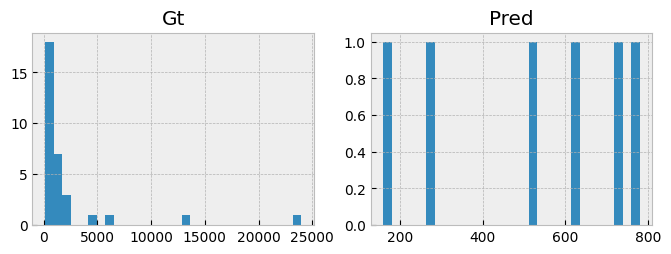

In [ ]:
fig, ax = plt.subplots(figsize=(8, 2.5), nrows=1, ncols=2)
ax.flat[0].hist(pred[pred<30**3], bins=30)
ax.flat[0].set_title("Gt")
ax.flat[1].hist(gt[gt<30**3], bins=30)
ax.flat[1].set_title("Pred")
plt.show()

In [ ]:
vol = np.asarray([j for file in files for j in torch.load(file)["img_in"]["volume"]])
vol.shape

(6,)

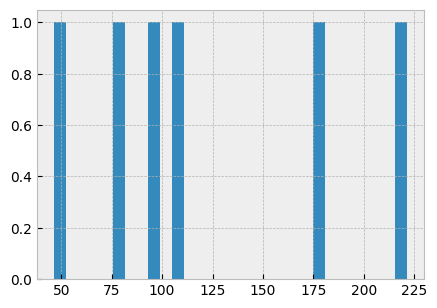

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.hist(vol[vol<10000], bins=30)
plt.show()

### From LungRads 
- Solid Nodules
    - benign <113
    - Prob benign >113, <268
    - suspisous >268 < 1767
    - very suspsious > 1767
    
- GGN 
    - 14137 and <14137
    
    
So from above we will create the following bins 
- <150
- 150-300
- 300-2400
- 2400>

In [ ]:
bins = [[0, 113], [113, 268], [268, 1767], [1767, 14137], [14137, np.inf]]
for _bin in bins:
    print(f"Volume range: {(_bin[0], _bin[1])}")
    print("GT nodule count:", gt[(gt>_bin[0]) & (gt<=_bin[1])].shape[0])
    print("Predicted nodule count:", pred[(pred>_bin[0]) & (pred<=_bin[1])].shape[0])
    sc = scores[(pred>_bin[0]) & (pred<=_bin[1])]
    print("Predicted nodule count with conf>0.9:", sc[sc>=0.9].shape[0])
    print(30*"-")

Volume range: (0, 113)
GT nodule count: 0
Predicted nodule count: 0
Predicted nodule count with conf>0.9: 0
------------------------------
Volume range: (113, 268)
GT nodule count: 1
Predicted nodule count: 9
Predicted nodule count with conf>0.9: 1
------------------------------
Volume range: (268, 1767)
GT nodule count: 5
Predicted nodule count: 16
Predicted nodule count with conf>0.9: 6
------------------------------
Volume range: (1767, 14137)
GT nodule count: 0
Predicted nodule count: 6
Predicted nodule count with conf>0.9: 0
------------------------------
Volume range: (14137, inf)
GT nodule count: 0
Predicted nodule count: 1
Predicted nodule count with conf>0.9: 1
------------------------------


In [ ]:
#| export 
def cuboid_volume_subset(vol, bins, index=0):
    _bin = bins[index]
    return (vol>_bin[0]) & (vol<=_bin[1])

In [ ]:
#| export
def volume_callback(x, bins, index=0): 
    keep_in = cuboid_volume_subset(np.asarray(x["img_in"]["volume"]), bins, index=index)
    x["img_in"]["boxes"] = x["img_in"]["boxes"][keep_in]
    return x["img_in"], x["img_out"]

In [ ]:
cuboid_volume(ds["img_in"]["boxes"])

array([260., 112., 112., 112., 128., 240., 162., 162., 216., 330.,  98.,
       360., 160., 112.,  98., 126., 128., 112., 144., 128., 180., 160.,
       720., 112., 180., 210., 140., 168.,  49., 144., 297., 144., 147.,
        49., 144., 128., 112., 112., 192., 126., 112., 144.,  70., 126.,
        98., 144., 420., 297., 112., 144.,  98.,  64., 112., 128., 192.,
       112., 112., 180.,  98.,  84.,  70., 120., 198., 112., 128.,  63.,
       144., 160.,  98., 561., 128., 270.,  49., 128., 160., 900.])

In [ ]:
cuboid_volume_subset(np.asarray(ds["img_in"]["volume"]), bins, 0)

array([False,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False])

In [ ]:
fps = np.linspace(0.0625, 8, num=300)
meters = [
    DetMetrics(iou_thr=j, conf_thr=i, froc_thresholds=fps.tolist())
    for j in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
    for i in [0.95, 0.9, 0.7]
]
[i.reset() for i in meters]
print("reset")

for file in tqdm(files):
    x = torch.load(file)
    img, img_out = x["img_in"], x["img_out"]
    keep = cuboid_volume_subset(np.asarray(x["img_in"]["volume"]), bins, index=0)
    for meter in meters: meter.update(img_out["boxes"], img_out["scores"], img["boxes"][keep])
metrics = [i.compute() for i in meters]

reset


100%|██████████| 30/30 [00:00<00:00, 252.95it/s]


bins

- bin_1(<113) = 0.53, 0.57, 1223
- bin_2(>113, <268) = 0.73, 0.76, 466
- bin_3(268, 1767) = 0.81, 0.84, 412
- bin_4(>1767) = 0.60, 0.62, 226

In [ ]:
#| export 
def convert2df(metrics):
    df = pd.DataFrame(metrics)
    for i in df.columns:
        df[i] = df[i].apply(lambda x: round(x, 2) if isinstance(x, (int, float)) else [round(i, 2) for i in x])
    return df[["conf", "iou", "FROC", "AP", "recall", "precision", "tp", "fp", "fn", "AP_interp", "FROC_interp", "FROC_thresholds", "avg_tp_iou"]]

In [ ]:
convert2df(metrics)[["conf", "iou", "FROC", "AP", "recall", "precision", "tp", "fp", "fn", "avg_tp_iou"]]

,conf,iou,FROC,AP,recall,precision,tp,fp,fn,avg_tp_iou
0,0.95,0.01,0.46,0.29,0.66,0.31,72.0,162.0,37.0,0.49
1,0.90,0.01,0.48,0.28,0.76,0.29,83.0,203.0,26.0,0.48
2,0.70,0.01,0.49,0.28,0.86,0.26,94.0,271.0,15.0,0.47
3,0.95,0.10,0.46,0.29,0.66,0.31,72.0,162.0,37.0,0.49
4,0.90,0.10,0.48,0.28,0.76,0.29,83.0,203.0,26.0,0.48
5,0.70,0.10,0.49,0.28,0.86,0.26,94.0,271.0,15.0,0.47
6,0.95,0.20,0.46,0.29,0.66,0.31,72.0,162.0,37.0,0.49
7,0.90,0.20,0.48,0.28,0.74,0.28,81.0,205.0,28.0,0.48
8,0.70,0.20,0.49,0.27,0.84,0.25,92.0,273.0,17.0,0.47
9,0.95,0.30,0.42,0.27,0.61,0.28,66.0,168.0,43.0,0.51


In [ ]:
#| export 
def compute_metrics_from_cache(meters: List[DetMetrics], files: Union[str, List[Union[str, PosixPath]]], callbacks: Union[Callable, List[Callable]] = None):
    # where callbacks is a function or a list of functions to apply in sequence
    files = files if isinstance(files, list) else Path(files).glob("*.pt")
    [i.reset() for i in meters]
    for file in tqdm(files):
        x = torch.load(file)
        img, img_out = x["img_in"], x["img_out"]
        if callbacks is not None:
            if isinstance(callbacks, list):
                for callback in callbacks:
                    x["img_in"], x["img_out"] = img, img_out
                    img, img_out = callback(x)
            else:
                img, img_out = callbacks(x)
        for meter in meters:
            meter.update(img_out["boxes"], img_out["scores"], img["boxes"])
    metrics = [i.compute() for i in meters]
    return convert2df(metrics)

In [ ]:
df_full = compute_metrics_from_cache(meters, files, callbacks=None)[["conf", "iou", "FROC", "AP", "recall", "precision", "tp", "fp", "fn", "avg_tp_iou"]]

100%|██████████| 30/30 [00:00<00:00, 119.67it/s]


In [ ]:
def generate_recall_curves(df):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    grouped_b = df.groupby('conf')
    ax[0].set_title('Recall v/s IoU')
    ax[0].set_xlabel('IoU')
    ax[0].set_ylabel('Recall')
    for key, group in grouped_b:
        ax[0].plot(group['iou'], group['recall'], marker='o', label=f'Conf={key}')
    ax[0].legend()

    grouped_a = df.groupby('iou')
    ax[1].set_title('Recall v/s Conf')
    ax[1].set_xlabel('Conf')
    ax[1].set_ylabel('Recall')
    for key, group in grouped_a:
        ax[1].plot(group['conf'], group['recall'], marker='o', label=f'IoU={key}')
    ax[1].legend()

    plt.tight_layout()
    plt.suptitle("Recall Curves", fontsize=16, fontweight="bold")
    plt.subplots_adjust(top=0.925, hspace=0.2)
    plt.show()

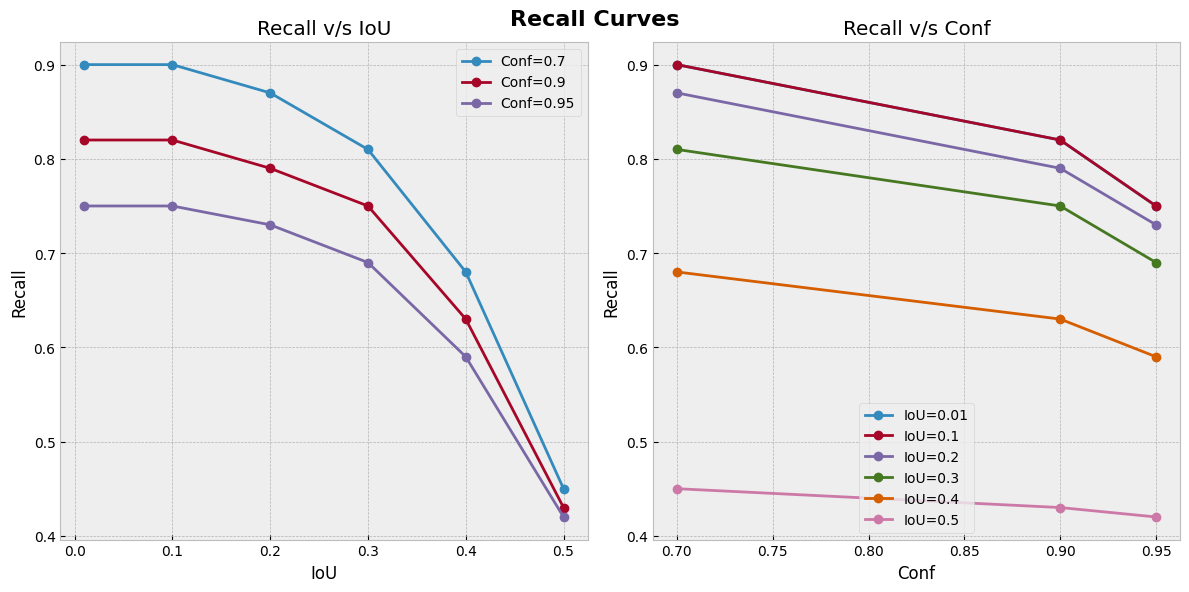

In [ ]:
generate_recall_curves(df=df_full)

In [ ]:
#| export 
texture_mapping = {
    "Non-Solid/GGO": "texture_non_solid",
    "non-Solid/Mixed": "texture_non_solid",
    "Non-Solid/Mixed": "texture_non_solid",
    "non solid": "texture_non_solid",
    "Solid": "texture_solid",
    "solid": "texture_solid",
    "Part Solid/Mixed": "texture_part_solid",
    "Solid/Mixed": "texture_part_solid",
    "part solid": "texture_part_solid",
    "texture_part_solid": "texture_part_solid", 
    "texture_non_solid": "texture_non_solid", 
    "texture_solid": "texture_solid",
}

In [ ]:
#| export 
def texture_subset(textures, target_texture='solid'):
    return textures == target_texture

In [ ]:
#| export
def texture_callback(x, texture): 
    textures = np.vectorize(texture_mapping.get)(np.asarray(x["img_in"]["texture"]))
    keep_in = texture_subset(textures, target_texture=np.asarray(texture_mapping[texture]))
    x["img_in"]["boxes"] = x["img_in"]["boxes"][keep_in]
    return x["img_in"], x["img_out"]

In [ ]:
keep_in = texture_subset(np.vectorize(texture_mapping.get)(np.asarray(x["img_in"]["texture"])), np.asarray(texture_mapping["solid"]))
boxes_in = ds["img_in"]["boxes"][keep_in]

> all nodules

In [ ]:
compute_metrics_from_cache(meters, files)[["conf", "iou", "FROC", "AP", "recall", "precision", "tp", "fp", "fn", "avg_tp_iou"]]

100%|██████████| 30/30 [00:00<00:00, 191.18it/s]


,conf,iou,FROC,AP,recall,precision,tp,fp,fn,avg_tp_iou
0,0.95,0.01,0.64,0.68,0.75,0.49,115.0,119.0,39.0,0.51
1,0.90,0.01,0.67,0.66,0.82,0.44,126.0,160.0,28.0,0.50
2,0.70,0.01,0.69,0.65,0.90,0.38,138.0,227.0,16.0,0.50
3,0.95,0.10,0.64,0.68,0.75,0.49,115.0,119.0,39.0,0.51
4,0.90,0.10,0.67,0.66,0.82,0.44,126.0,160.0,28.0,0.50
5,0.70,0.10,0.69,0.65,0.90,0.38,138.0,227.0,16.0,0.50
6,0.95,0.20,0.63,0.67,0.73,0.48,113.0,121.0,41.0,0.52
7,0.90,0.20,0.66,0.66,0.79,0.43,122.0,164.0,32.0,0.52
8,0.70,0.20,0.67,0.64,0.87,0.37,134.0,231.0,20.0,0.51
9,0.95,0.30,0.60,0.65,0.69,0.46,107.0,127.0,47.0,0.54


In [ ]:
show_cols = ["conf", "iou", "FROC", "AP", "recall", "precision", "tp", "fp", "fn", "avg_tp_iou"]

## Subgroup Analysis: Volume

> tiny nodules(<113)

In [ ]:
bins

[[0, 113], [113, 268], [268, 1767], [1767, 14137], [14137, inf]]

In [ ]:
compute_metrics_from_cache(meters, files, callbacks=partial(volume_callback, bins=bins, index=0))[["conf", "iou", "FROC", "AP", "recall", "precision", "tp", "fp", "fn", "avg_tp_iou"]]

100%|██████████| 30/30 [00:00<00:00, 272.90it/s]


,conf,iou,FROC,AP,recall,precision,tp,fp,fn,avg_tp_iou
0,0.95,0.01,0.46,0.29,0.66,0.31,72.0,162.0,37.0,0.49
1,0.90,0.01,0.48,0.28,0.76,0.29,83.0,203.0,26.0,0.48
2,0.70,0.01,0.49,0.28,0.86,0.26,94.0,271.0,15.0,0.47
3,0.95,0.10,0.46,0.29,0.66,0.31,72.0,162.0,37.0,0.49
4,0.90,0.10,0.48,0.28,0.76,0.29,83.0,203.0,26.0,0.48
5,0.70,0.10,0.49,0.28,0.86,0.26,94.0,271.0,15.0,0.47
6,0.95,0.20,0.46,0.29,0.66,0.31,72.0,162.0,37.0,0.49
7,0.90,0.20,0.48,0.28,0.74,0.28,81.0,205.0,28.0,0.48
8,0.70,0.20,0.49,0.27,0.84,0.25,92.0,273.0,17.0,0.47
9,0.95,0.30,0.42,0.27,0.61,0.28,66.0,168.0,43.0,0.51


> small nodules(113, 268)

In [ ]:
compute_metrics_from_cache(meters, files, callbacks=partial(volume_callback, bins=bins, index=1))[["conf", "iou", "FROC", "AP", "recall", "precision", "tp", "fp", "fn", "avg_tp_iou"]]

100%|██████████| 30/30 [00:00<00:00, 374.68it/s]


,conf,iou,FROC,AP,recall,precision,tp,fp,fn,avg_tp_iou
0,0.95,0.01,0.70,0.17,0.96,0.11,25.0,209.0,1.0,0.55
1,0.90,0.01,0.70,0.16,0.96,0.09,25.0,261.0,1.0,0.55
2,0.70,0.01,0.70,0.16,1.00,0.07,26.0,339.0,0.0,0.56
3,0.95,0.10,0.70,0.17,0.96,0.11,25.0,209.0,1.0,0.55
4,0.90,0.10,0.70,0.16,0.96,0.09,25.0,261.0,1.0,0.55
5,0.70,0.10,0.70,0.16,1.00,0.07,26.0,339.0,0.0,0.56
6,0.95,0.20,0.70,0.17,0.96,0.11,25.0,209.0,1.0,0.55
7,0.90,0.20,0.70,0.16,0.96,0.09,25.0,261.0,1.0,0.55
8,0.70,0.20,0.70,0.16,1.00,0.07,26.0,339.0,0.0,0.56
9,0.95,0.30,0.70,0.17,0.96,0.11,25.0,209.0,1.0,0.55


> medium nodules(268, 1767)

In [ ]:
compute_metrics_from_cache(meters, files, callbacks=partial(volume_callback, bins=bins, index=2))[["conf", "iou", "FROC", "AP", "recall", "precision", "tp", "fp", "fn", "avg_tp_iou"]]

100%|██████████| 30/30 [00:00<00:00, 341.46it/s]


,conf,iou,FROC,AP,recall,precision,tp,fp,fn,avg_tp_iou
0,0.95,0.01,0.86,0.35,1.00,0.06,13.0,221.0,0.0,0.57
1,0.90,0.01,0.86,0.35,1.00,0.05,13.0,273.0,0.0,0.57
2,0.70,0.01,0.86,0.35,1.00,0.04,13.0,352.0,0.0,0.57
3,0.95,0.10,0.86,0.35,1.00,0.06,13.0,221.0,0.0,0.57
4,0.90,0.10,0.86,0.35,1.00,0.05,13.0,273.0,0.0,0.57
5,0.70,0.10,0.86,0.35,1.00,0.04,13.0,352.0,0.0,0.57
6,0.95,0.20,0.83,0.35,0.92,0.05,12.0,222.0,1.0,0.60
7,0.90,0.20,0.83,0.35,0.92,0.04,12.0,274.0,1.0,0.60
8,0.70,0.20,0.83,0.35,0.92,0.03,12.0,353.0,1.0,0.60
9,0.95,0.30,0.83,0.35,0.92,0.05,12.0,222.0,1.0,0.60


> large nodules(>1767)

In [ ]:
compute_metrics_from_cache(meters, files, callbacks=partial(volume_callback, bins=bins, index=3))[["conf", "iou", "FROC", "AP", "recall", "precision", "tp", "fp", "fn", "avg_tp_iou"]]

100%|██████████| 30/30 [00:00<00:00, 572.92it/s]


,conf,iou,FROC,AP,recall,precision,tp,fp,fn,avg_tp_iou
0,0.95,0.01,0.73,0.11,0.75,0.01,3.0,231.0,1.0,0.73
1,0.90,0.01,0.73,0.10,0.75,0.01,3.0,283.0,1.0,0.73
2,0.70,0.01,0.73,0.10,0.75,0.01,3.0,362.0,1.0,0.73
3,0.95,0.10,0.73,0.11,0.75,0.01,3.0,231.0,1.0,0.73
4,0.90,0.10,0.73,0.10,0.75,0.01,3.0,283.0,1.0,0.73
5,0.70,0.10,0.73,0.10,0.75,0.01,3.0,362.0,1.0,0.73
6,0.95,0.20,0.73,0.11,0.75,0.01,3.0,231.0,1.0,0.73
7,0.90,0.20,0.73,0.10,0.75,0.01,3.0,283.0,1.0,0.73
8,0.70,0.20,0.73,0.10,0.75,0.01,3.0,362.0,1.0,0.73
9,0.95,0.30,0.73,0.11,0.75,0.01,3.0,231.0,1.0,0.73


In [ ]:
compute_metrics_from_cache(meters, files, callbacks=partial(volume_callback, bins=bins, index=4))[["conf", "iou", "FROC", "AP", "recall", "precision", "tp", "fp", "fn", "avg_tp_iou"]]

100%|██████████| 30/30 [00:00<00:00, 693.45it/s]


,conf,iou,FROC,AP,recall,precision,tp,fp,fn,avg_tp_iou
0,0.95,0.01,0.49,0.01,1.0,0.01,2.0,232.0,0.0,0.29
1,0.90,0.01,0.49,0.01,1.0,0.01,2.0,284.0,0.0,0.29
2,0.70,0.01,0.49,0.01,1.0,0.01,2.0,363.0,0.0,0.29
3,0.95,0.10,0.49,0.01,1.0,0.01,2.0,232.0,0.0,0.29
4,0.90,0.10,0.49,0.01,1.0,0.01,2.0,284.0,0.0,0.29
5,0.70,0.10,0.49,0.01,1.0,0.01,2.0,363.0,0.0,0.29
6,0.95,0.20,0.44,0.01,0.5,0.00,1.0,233.0,1.0,0.37
7,0.90,0.20,0.44,0.01,0.5,0.00,1.0,285.0,1.0,0.37
8,0.70,0.20,0.44,0.01,0.5,0.00,1.0,364.0,1.0,0.37
9,0.95,0.30,0.44,0.01,0.5,0.00,1.0,233.0,1.0,0.37


## Subgroup Analysis: Texture

> solid nodules

In [ ]:
df_solid = compute_metrics_from_cache(meters, files, callbacks=partial(texture_callback, texture='solid'))[["conf", "iou", "FROC", "AP", "recall", "precision", "tp", "fp", "fn", "avg_tp_iou"]]
df_solid

100%|██████████| 30/30 [00:00<00:00, 217.06it/s]


,conf,iou,FROC,AP,recall,precision,tp,fp,fn,avg_tp_iou
0,0.95,0.01,0.63,0.65,0.75,0.48,112.0,122.0,38.0,0.51
1,0.90,0.01,0.66,0.64,0.82,0.43,123.0,163.0,27.0,0.50
2,0.70,0.01,0.68,0.62,0.90,0.37,135.0,230.0,15.0,0.50
3,0.95,0.10,0.63,0.65,0.75,0.48,112.0,122.0,38.0,0.51
4,0.90,0.10,0.66,0.64,0.82,0.43,123.0,163.0,27.0,0.50
5,0.70,0.10,0.68,0.62,0.90,0.37,135.0,230.0,15.0,0.50
6,0.95,0.20,0.62,0.65,0.73,0.47,110.0,124.0,40.0,0.52
7,0.90,0.20,0.65,0.63,0.79,0.42,119.0,167.0,31.0,0.51
8,0.70,0.20,0.66,0.62,0.87,0.36,131.0,234.0,19.0,0.51
9,0.95,0.30,0.59,0.63,0.69,0.44,104.0,130.0,46.0,0.53


> part solid nodules

In [ ]:
compute_metrics_from_cache(meters, files, callbacks=partial(texture_callback, texture='part solid'))[["conf", "iou", "FROC", "AP", "recall", "precision", "tp", "fp", "fn", "avg_tp_iou"]]

100%|██████████| 30/30 [00:00<00:00, 701.64it/s]


,conf,iou,FROC,AP,recall,precision,tp,fp,fn,avg_tp_iou
0,0.95,0.01,0.92,0.06,1.0,0.01,2.0,232.0,0.0,0.50
1,0.90,0.01,0.92,0.06,1.0,0.01,2.0,284.0,0.0,0.50
2,0.70,0.01,0.92,0.06,1.0,0.01,2.0,363.0,0.0,0.50
3,0.95,0.10,0.92,0.06,1.0,0.01,2.0,232.0,0.0,0.50
4,0.90,0.10,0.92,0.06,1.0,0.01,2.0,284.0,0.0,0.50
5,0.70,0.10,0.92,0.06,1.0,0.01,2.0,363.0,0.0,0.50
6,0.95,0.20,0.92,0.06,1.0,0.01,2.0,232.0,0.0,0.50
7,0.90,0.20,0.92,0.06,1.0,0.01,2.0,284.0,0.0,0.50
8,0.70,0.20,0.92,0.06,1.0,0.01,2.0,363.0,0.0,0.50
9,0.95,0.30,0.92,0.06,1.0,0.01,2.0,232.0,0.0,0.50


> non solid nodules

In [ ]:
compute_metrics_from_cache(meters, files, callbacks=partial(texture_callback, texture='non solid'))[["conf", "iou", "FROC", "AP", "recall", "precision", "tp", "fp", "fn", "avg_tp_iou"]]

100%|██████████| 30/30 [00:00<00:00, 676.22it/s]


,conf,iou,FROC,AP,recall,precision,tp,fp,fn,avg_tp_iou
0,0.95,0.01,0.33,0.0,0.5,0.0,1.0,233.0,1.0,0.79
1,0.90,0.01,0.33,0.0,0.5,0.0,1.0,285.0,1.0,0.79
2,0.70,0.01,0.33,0.0,0.5,0.0,1.0,364.0,1.0,0.79
3,0.95,0.10,0.33,0.0,0.5,0.0,1.0,233.0,1.0,0.79
4,0.90,0.10,0.33,0.0,0.5,0.0,1.0,285.0,1.0,0.79
5,0.70,0.10,0.33,0.0,0.5,0.0,1.0,364.0,1.0,0.79
6,0.95,0.20,0.33,0.0,0.5,0.0,1.0,233.0,1.0,0.79
7,0.90,0.20,0.33,0.0,0.5,0.0,1.0,285.0,1.0,0.79
8,0.70,0.20,0.33,0.0,0.5,0.0,1.0,364.0,1.0,0.79
9,0.95,0.30,0.33,0.0,0.5,0.0,1.0,233.0,1.0,0.79


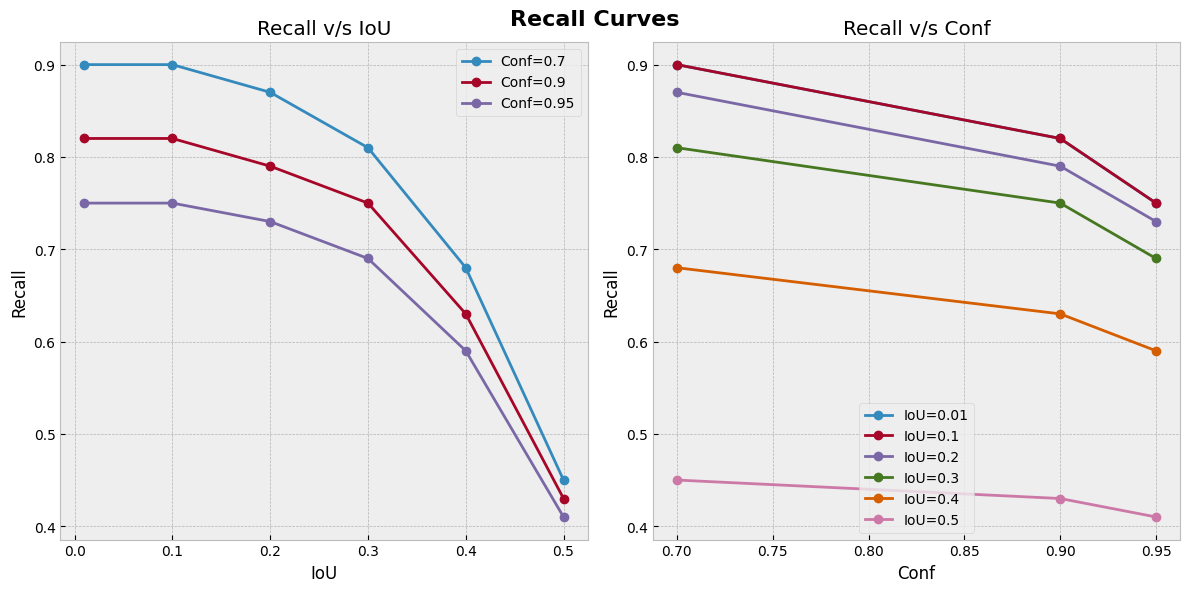

In [ ]:
generate_recall_curves(df=df_solid)

In [ ]:
ds["img_in"].keys(), ds["img_out"].keys()

(dict_keys(['boxes', 'volume', 'texture']), dict_keys(['boxes', 'scores']))

In [ ]:
#| export
def get_scan_stats(pred_bbox: np.ndarray, pred_scores: np.ndarray, gt_bbox: np.ndarray, conf_thr: float, iou_thr: float):
    keep = pred_scores >= conf_thr
    pred_bbox = pred_bbox[keep]
    pred_scores = pred_scores[keep]
    tp, fp, fn, tp_iou = assign_tp_fp_fn_linear_assignment(pred_bbox, gt_bbox, iou_thr=iou_thr)
    return tp, fp, fn, tp_iou

In [ ]:
pred_bbox = ds["img_out"]["boxes"]
pred_scores = ds["img_out"]["scores"]
gt_bbox = ds["img_in"]["boxes"]
conf_thr = 0.9
iou_thr = 0.1

In [ ]:
tp, fp, fn, tp_iou = get_scan_stats(pred_bbox=pred_bbox, pred_scores=pred_scores, gt_bbox=gt_bbox, conf_thr=conf_thr, iou_thr=iou_thr)

In [ ]:
np.sum(tp), np.sum(fp), np.sum(fn)

(64.0, 89.0, 12.0)

In [ ]:
ds["img_in"]["boxes"].shape

(76, 6)

In [ ]:
#| export
def get_dataset_stats(files, conf_thr=0.9, iou_thr=0.1) -> pd.DataFrame:
    stats = {}
    # files is a list of paths of cached .pt files with input and output bboxes, output scores and input texture and volume info
    for file in files:
        ds = torch.load(file)
        num_nodules = ds["img_in"]["boxes"].shape[0]
        tp, fp, fn, tp_iou = get_scan_stats(pred_bbox=ds["img_out"]["boxes"], pred_scores=ds["img_out"]["scores"], gt_bbox=ds["img_in"]["boxes"], conf_thr=conf_thr, iou_thr=iou_thr)
        sensitivity = np.cumsum(tp)/(sum(tp)+sum(fn))
        stats[file.stem] = {
            "num_nodules": num_nodules,
            "tp": np.sum(tp),
            "fp": np.sum(fp),
            "fn": np.sum(fn),
            "recall": sensitivity.max() if sensitivity.size else 0,
            "avg_tp_iou": 0 if not tp_iou.size else np.mean(tp_iou, axis=0)
        }
    df = pd.DataFrame.from_dict(stats, orient='index')
    df.index.name = 'sid'
    df.reset_index(inplace=True)
    return df

In [ ]:
#| export
def get_dataset_summary(dirs, root, conf_thr=0.9, iou_thr=0.1):
    summary = {}
    for dataset_name in tqdm(dirs):
        if isinstance(dataset_name, list): continue
        files = get_all_file_locs(root=root, read_dir=dataset_name)
        df = get_dataset_stats(files, conf_thr=conf_thr, iou_thr=iou_thr)
        summary[dataset_name] = {}
        summary[dataset_name]['num_scans'] = df.shape[0]
        summary[dataset_name]['num_nodules'] = df["num_nodules"].sum()
    return summary

In [ ]:
files = get_all_file_locs(root="/home/users/utkarsh.singh/qct/qct_nodule_detection/weights/v002/prod/", read_dir=["dsb_test"])
df = get_dataset_stats(files)

In [ ]:
df

,sid,num_nodules,tp,fp,fn,recall,avg_tp_iou
0,2.25.61246657820584493337413046819948950717605...,4,3.0,0.0,1.0,0.750000,0.455700
1,2.25.96948820079210808834018301990372398717162...,1,1.0,0.0,0.0,1.000000,0.734362
2,2.25.53791596399672760796794646828734431811253...,3,3.0,0.0,0.0,1.000000,0.634715
3,2.25.43492213913172028512632996764300606074911...,1,1.0,0.0,0.0,1.000000,0.562323
4,2.25.65967389543427680840828387499208499172834...,2,2.0,3.0,0.0,1.000000,0.556707
5,2.25.48038340065917841022308085607852719672696...,1,1.0,0.0,0.0,1.000000,0.704148
6,2.25.11206602142046824015054090995126046473403...,5,4.0,2.0,1.0,0.800000,0.374215
7,2.25.13211458368385336379814583086672754159300...,2,2.0,5.0,0.0,1.000000,0.484925
8,2.25.74304873107613869989845057539978442851534...,1,1.0,4.0,0.0,1.000000,0.722481
9,2.25.99661199007439401706301781390306268041620...,2,2.0,3.0,0.0,1.000000,0.571912


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()